In [1]:
# libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import findspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t

from pyspark.sql.types import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
# builds spark session
spark = SparkSession.builder.master("local").appName("Spark Builder").getOrCreate()

In [3]:
# uploads csv file
growthFile = spark.read.csv("growth.csv", 
                          header=True, nullValue="unknown", mode='Overwrite',
                          inferSchema=True, sep=","
                         )

## <span style="color:#2eb0a8">1. Descriptive</span>

In [4]:
# creates binary variables for each characteristic or feature

desc =  (growthFile
       .agg(f.sum(f.when(~f.col('store').isNull(),1).otherwise(0)).alias('has_store'),
            f.sum(f.when(~f.col('network_name').isNull(),1).otherwise(0)).alias('has_nw_name'),
            f.sum(f.when(~f.col('click_time').isNull(),1).otherwise(0)).alias('has_click_time'),
            f.sum(f.when(~f.col('city').isNull(),1).otherwise(0)).alias('has_city'),
            f.sum(f.when(~f.col('country').isNull(),1).otherwise(0)).alias('has_country'),
            f.sum(f.when(~f.col('device_type').isNull(),1).otherwise(0)).alias('has_dv_type'),
            f.sum(f.when(~f.col('device_name').isNull(),1).otherwise(0)).alias('has_dv_name'),
            f.sum(f.when(~f.col('os_name').isNull(),1).otherwise(0)).alias('has_os_name'),
            f.sum(f.when(~f.col('activity_kind').isNull(),1).otherwise(0)).alias('has_activity_kind'),
            f.sum(f.when(~f.col('event_name').isNull(),1).otherwise(0)).alias('has_event_name'),
            f.sum(f.when(~f.col('installed_at').isNull(),1).otherwise(0)).alias('has_install_date'),
            f.sum(f.when(~f.col('created_at').isNull(),1).otherwise(0)).alias('has_created_date'))
      )

In [5]:
descriptive = desc.toPandas().transpose().rename(columns={0:'total'})

In [6]:
descriptive['percent_total'] = round(descriptive['total']/12724,2)
descriptive

,total,percent_total
has_store,12724,1.00
has_nw_name,12724,1.00
has_click_time,7260,0.57
has_city,11375,0.89
has_country,12724,1.00
has_dv_type,8451,0.66
has_dv_name,12724,1.00
has_os_name,8451,0.66
has_activity_kind,8451,0.66
has_event_name,8451,0.66


## <span style="color:#e74faa">Insights & Recommendations</span>

- <b>Click Time:</b> over 40% missing data. As it refers to ad tapping activity, this doesn't present a major issue. However, it would be good to set a tolerance threshold (or use an industry benchmark) to monitor and compare performance over time.
<hr>
- <b>Cities:</b> there is an opportunity to standardise this information, by creating categories for grouping key markets as well as adding city or location ids for better data storage and retrieval.
<hr>
- <b>Device Type:</b> similarly to cities, there is an opportunity to standardise this information through device_ids.
<hr>
- <b>Installed and Created Dates:</b> this example shows a single table that can be broken down into multiple and less cluttered ones. On the one hand, we have a log table for keeping all event activity regardless of the stage the user is in (installation --> room initiation --> room creation), and on the other, we have more static information such as location, OS and device type. Within the log tables, there is an opportunity to further refine key events by building tables around use cases (e.g. need / purpose for data usage).

## <span style="color:#2eb0a8">2. Installations & Room Creation</span>

In [7]:
installsOS = (growthFile
             .where(f.col('event_name')=='install')
             .groupBy('os_name', 'city',f.to_date('created_at').alias('install_date'))
             .agg(f.countDistinct('user_id').alias('total_installs'))
             .orderBy(f.desc('total_installs'))
             )

In [8]:
# inputs total number of app installations
installsOS.toPandas()['total_installs'].sum()

7056

In [9]:
# limits output to top 20 results
installsOS_top = (installsOS
                    .groupBy('city','os_name')
                    .agg(f.sum('total_installs').alias('total_installs'))
                    .sort(f.desc('total_installs'))
                    .limit(20)
                    .dropna()
                   )

In [10]:
installsOS_top20 = installsOS_top.toPandas()
installsOS_top20.head()

,city,os_name,total_installs
0,Madrid,android,1248
1,Barcelona,android,914
2,Rome,android,455
3,Valencia,android,313
4,London,android,244


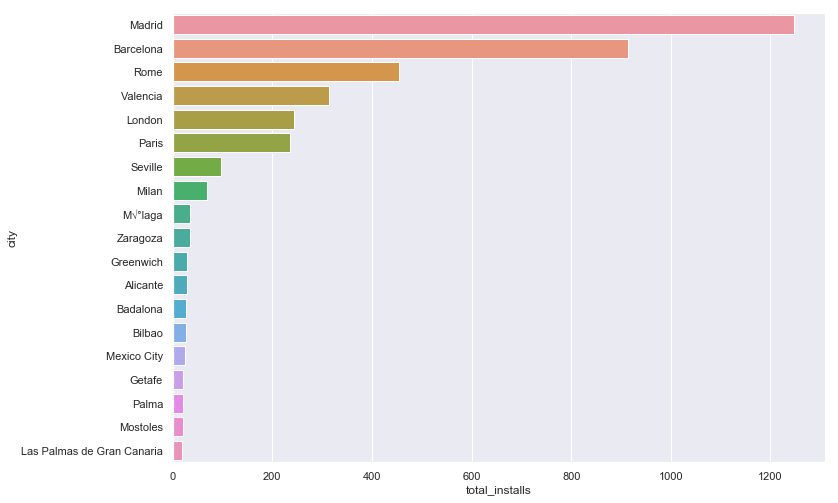

In [11]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(y=installsOS_top20['city'], x=installsOS_top20['total_installs'])
plt.show()

In [12]:
roomsOS =    (growthFile
             .where(f.col('event_name')=='room.list.form.create')
             .groupBy('os_name', 'city',f.to_date('created_at').alias('room_creation_date'))
             .agg(f.count('event_name').alias('total_rooms'))
             .orderBy(f.desc('total_rooms'))
             )

In [13]:
# inputs total number of rooms posted
roomsOS.toPandas()['total_rooms'].sum()

499

In [14]:
# limits output to top 20 results
roomsOS_top = (roomsOS
                 .groupBy('city','os_name')
                 .agg(f.sum('total_rooms').alias('total_rooms'))
                 .sort(f.desc('total_rooms'))
                 .limit(20)
                 .dropna()
                )

In [15]:
roomsOS_top20 = roomsOS_top.toPandas()
roomsOS_top20.head()

,city,os_name,total_rooms
0,Barcelona,android,130
1,Madrid,android,127
2,Valencia,android,18
3,Seville,android,15
4,Rome,android,10


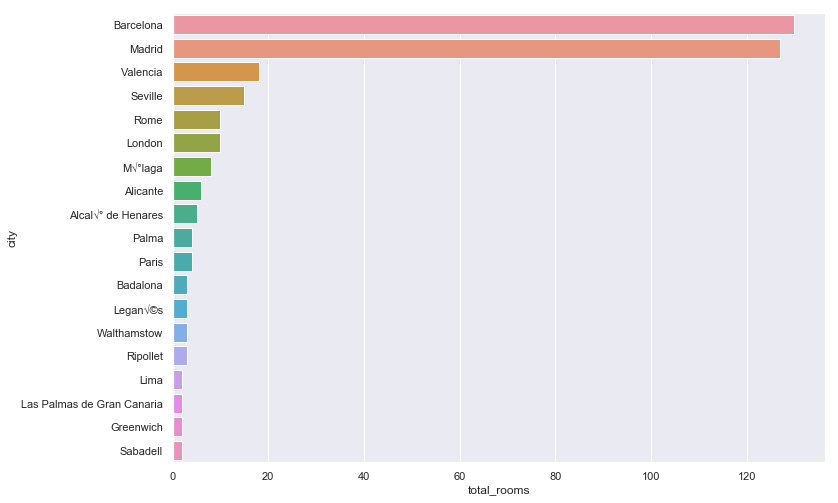

In [16]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(y=roomsOS_top20['city'], x=roomsOS_top20['total_rooms'])
plt.show()

In [17]:
# distributes data by day difference
distr = ((installsOS
         .join(roomsOS,['os_name','city'],'left')
         .withColumn('date_diff', f.datediff('room_creation_date','install_date'))
        ).fillna({'date_diff' : 0,
                  'total_rooms' :0,
                 'os_name' : 'none',
                 'city' : 'none'})).toPandas()

In [18]:
distr['date_diff'].count()

1659

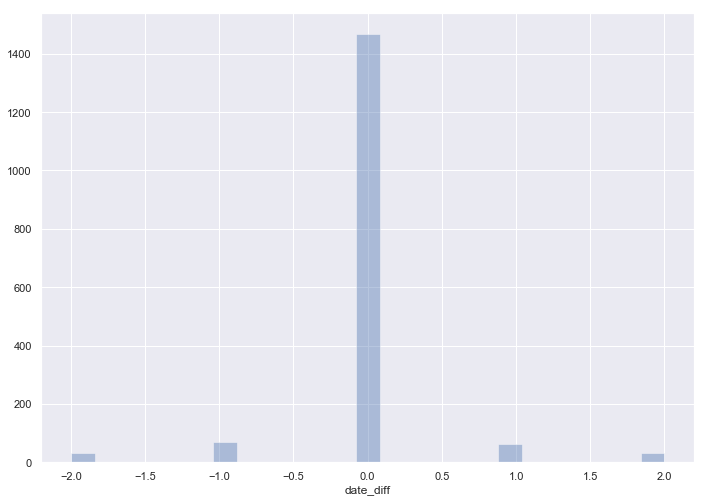

In [19]:
from scipy import stats

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(distr['date_diff'], bins=25, kde=False)
plt.show()

## <span style="color:#e74faa">Insights</span>

- <b>The market is heavily skewed towards large metropolitan areas in Europe</b>. Long tail cities account for less than 1/5 in terms of volume of installations and room creation. 
<hr>
- <b>18% and 13% of app installations come from Madrid and Barcelona respectively</b>. Rome, Valencia, London and Paris come shortly after. Valencia seems to be a deviant case when compared to the rest of the group - this might be due to the product's strategic positioning in Spain.
<hr>
- <b>Over 50% of rooms created come from Barcelona and Madrid</b>, followed by Valencia, Seville, Rome and London. The majority of the remaining rooms posted take place in Spanish cities.
<hr>
- <b>Over 75% of users who post a room do so within 24 hours from installing the app</b>. There are also a few cases in which the data is incorrect and thus a negative day difference is observed.

## <span style="color:#2eb0a8"> 3. Time Series</span>

In [20]:
installs = (growthFile
            .where(f.col('event_name')=='install')
            .groupBy(f.to_date('created_at').alias('yyyy_mm_dd'), 'city')
            .agg(f.countDistinct('user_id').alias('installs'))
            .orderBy(f.desc('yyyy_mm_dd'), f.desc('installs'))
            .join(installsOS_top,'city','inner')
            .dropna()
           ).toPandas()

In [21]:
installs.head()

,city,yyyy_mm_dd,installs,os_name,total_installs
0,Madrid,2018-10-03,348,android,1248
1,Barcelona,2018-10-03,311,android,914
2,Rome,2018-10-03,166,android,455
3,Paris,2018-10-03,92,android,235
4,Valencia,2018-10-03,87,android,313


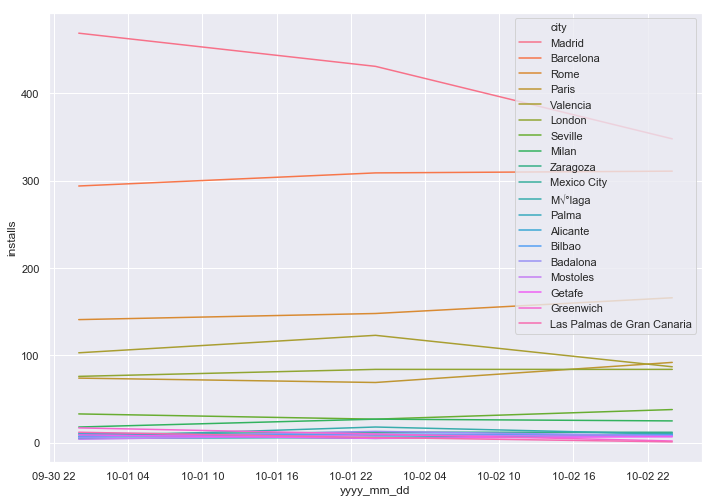

In [22]:
sns.lineplot(data=installs, x="yyyy_mm_dd", y="installs", hue='city')
plt.show()

In [23]:
rooms =    (growthFile
            .where(f.col('event_name')=='room.list.form.create')
            .groupBy(f.to_date('created_at').alias('yyyy_mm_dd'), 'city')
            .agg(f.count('event_name').alias('rooms'))
            .orderBy(f.desc('yyyy_mm_dd'), f.desc('rooms'))
            .join(roomsOS_top,'city','inner')
            .dropna()
           ).toPandas()

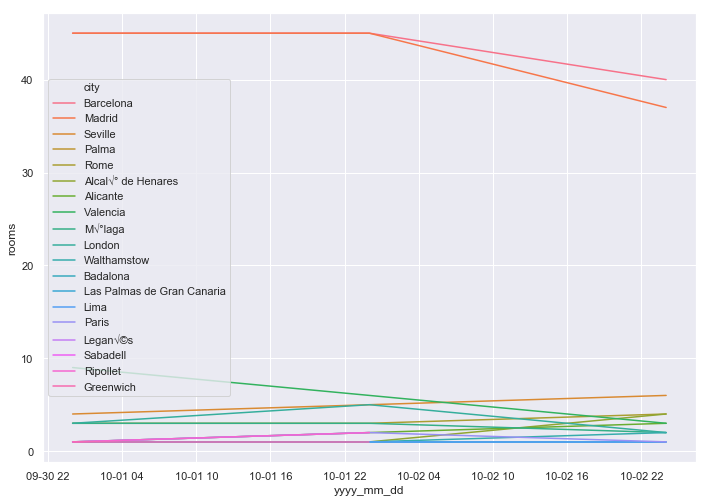

In [24]:
sns.lineplot(data=rooms, x="yyyy_mm_dd", y="rooms", hue='city')
plt.show()

## <span style="color:#e74faa">Insights</span>

- <b>Madrid and Paris have seen a steady decrease in the number of app installations during October 2018</b>. On the other hand, Barcelona and Rome show an upwards trend in installations during the same month.
<hr>
- From mid-October, Barcelona, Valencia and Madrid began to slow down in the number of rooms posted. This might reflect a seasonal pattern.

## <span style="color:#2eb0a8">4. Network Performance</span>

In [25]:
NetworkRooms = (growthFile
                .withColumn('room_created_date', f.when(f.col('event_name')=='room.list.form.create',f.to_date('created_at')).otherwise(f.lit(None)))    
                .where(~f.col('room_created_date').isNull())
                .select('network_name','room_created_date','user_id')
               )

NetworkInstalls = (growthFile
                   .withColumn('install_created_date', f.when(f.col('event_name')=='install',f.to_date('created_at')).otherwise(f.lit(None)))
                   .where(~f.col('install_created_date').isNull()) 
                   .select('network_name','install_created_date','user_id')
                   .join(NetworkRooms,['network_name','user_id'],'left')
                   .where(~f.col('room_created_date').isNull())
                   .withColumn('date_diff', f.datediff('room_created_date','install_created_date'))
                   .groupBy('network_name')
                   .agg(f.avg('date_diff').alias('avg_date_diff'))
                  )

NetworkMetrics = (growthFile
                  .groupBy('network_name')
                  .agg(f.sum(f.when(f.col('event_name')=='install', 1).otherwise(0)).alias('nr_installs'),
                       f.sum(f.when(f.col('event_name')=='room.list.form.init', 1).otherwise(0)).alias('nr_rooms_started'),
                       f.sum(f.when(f.col('event_name')=='room.list.form.create', 1).otherwise(0)).alias('nr_rooms_created'),
                       f.sum(f.when(~f.col('click_time').isNull(), 1).otherwise(0)).alias('nr_ads_clicked')
                      )
                  .join(NetworkInstalls,'network_name','left')
                 ).toPandas()

In [26]:
NetworkMetrics['network_nr'] = NetworkMetrics['network_name'].map(lambda x: x.lstrip('Network ').rstrip('')).astype('int')
NetworkMetrics.set_index(NetworkMetrics['network_nr'], inplace=True)
NetworkMetrics = NetworkMetrics.sort_index()

del NetworkMetrics['network_nr']

In [27]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

s = NetworkMetrics.style.background_gradient(cmap=cm)
s

## <span style="color:#e74faa">Insights</span>

- There are a number of different ways one could look at network performance. 
<hr>
<b>I have included in the table above a list of those I believe could help assess how well they are able to deliver a seamless user experience</b> (assuming the network is key for enabling connectivity between the user and the app):
<hr>
- <b>In short, networks 2 and 4 show the best results</b>, bringing a large number of installations, rooms initiated and created as well as a short lead time for posting rooms.
<hr>
- These two networks also have a much higher conversion rate from room initiating to posting (between 51 and 60%).

#### <span style="color:#e74faa">Online Marketing Campaigns</span> 
There are quite many fields missing to help us assess such campaigns, here are a few:
- UTM parameters (source, channels, campaigns, etc)
- a session-based definition/approach for grouping events and attribution
- the value of the rooms initiated / posted

## <span style="color:#2eb0a8">5. Growth Marketing</span>


In [28]:
cohort_items = (growthFile
               .withColumn('install_date', f.when(f.col('event_name')=='install',
                              f.to_date('created_at')).otherwise(f.lit(None)))
               .withColumn("cohort_month", f.trunc("install_date", "month"))
               .select('user_id','cohort_month')
               .where(~f.col('user_id').isNull())
               )

In [29]:
user_activities = (growthFile
                   .withColumn('room_created_date', f.when(f.col('event_name')=='room.list.form.create',
                                                    f.to_date('created_at')).otherwise(f.lit(None)))
                   .withColumn("room_month", f.trunc("room_created_date", "month"))
                   .select('user_id','room_month')
                   .where(~f.col('user_id').isNull())
                   .join(cohort_items,'user_id','right')
                   .withColumn('month_number', f.datediff('room_month','cohort_month'))
                   .select('user_id','month_number')
                   )

In [30]:
cohort_size = (cohort_items
               .groupBy('cohort_month')
               .agg(f.countDistinct('user_id').alias('cohort_users'))
              )

In [31]:
retention_table = (user_activities
                   .join(cohort_items,'user_id','right')
                   .groupBy('cohort_month','month_number')
                   .agg(f.countDistinct('user_id').alias('nr_users'))
                  )

In [32]:
cohort_table = (retention_table
                .join(cohort_size, 'cohort_month','left')
                .withColumn('percentage', f.round(f.col('nr_users')/f.col('cohort_users'),2))
                .select('cohort_month','cohort_users','month_number',f.col('nr_users').alias('total_users'),'percentage')
                .where(~f.col('cohort_month').isNull())
                .where(~f.col('month_number').isNull())
               ).toPandas()

In [33]:
import seaborn as sns

sm = sns.light_palette("red", as_cmap=True)

xs = cohort_table.style.background_gradient(cmap=sm)
xs

## <span style="color:#e74faa">Insights</span>

- <b>Funnel management is important because it help us understand pain points users face, identify potential issues with the product's growth and acquisition strategy as well as assess the performance of operational teams.</b>
<hr>
Funnel management is a fundamental component of performance marketing as teams want to be able to acquire users in an efficient manner, optimise campaigns for better conversion and find ways to retain users in the long run.
<hr>
In the example above, we see that of the users that installed the app roughly 2% posted a room the same month. Such a low retention could potentially lead to lower engagement or it could, eventually, signal a bigger issue with usability, attractiveness or market shortcomings. 

## <span style="color:#2eb0a8">6. Growth Marketing</span>


## <span style="color:#e74faa">Demand-side Metrics</span>
The following metrics will help in understanding demand:
<hr>
- New User retention
- Return Rate (existing users)
- Session Time
- Net Promoter Score (how likely are they to recommend product to other users)
- Customer Lifetime Value
- Acquisition Cost
- Liquidity (demand: how fast do I find/book a room I need, supply: how fast do I sell a room)
- Shelf life (how long does a room remain posted before it is actually booked)
- Monthly Recurring Revenue
- Average Sold Value (similarly to the hospitality industry's ADR)